In [16]:
from netCDF4 import Dataset
from glob import glob
import os, sys
import matplotlib.pyplot as plt
import numpy as np

from wrf import getvar, to_np, extract_times, ALL_TIMES, vertcross, CoordPair

is_py = os.path.basename(sys.argv[0]) == 'vert-wind-contour-vid-by-landuse.ju.py'

# All ids of the runs we want to plot, separated by series
# {
#     "Landuse 1": [LANDUSE1_RUN_ID_1, LANDUSE1_RUN_ID_2, ...],
#     "Landuse 2": [LANDUSE2_RUN_ID_1, LANDUSE2_RUN_ID_2, ...],
#     ... ,
# }
RUN_IDS = {
    # 'grassland':    [46, 63, 45],
    # 'barren':       [52, 73, 51],
    # 'forest':       [58, 68, 57],

    'grassland':    [45, 47, 64],
    'barren':       [51, 53, 74],
    'forest':       [57, 59, 69],
}

# Z0_URB2D              Roughness length for momentum
# AHE                   Anthropogenic heat emission

VAR_UNITS = {
    'AHE':      '$W/m^2$',
    'Z0_URB2D': 'm',
}

INDEPENDENT_VAR = 'Z0_URB2D'

root_dir = '/home/guc/'
data_dir = f'tmp/'
image_dir = glob(root_dir + data_dir)[0]
dummy_dataset = Dataset(glob(f'{root_dir}runs/045-*/wrfout*')[0])
z_data = getvar(dummy_dataset, "z", timeidx=0)

if len(glob(image_dir)) == 0:
    os.mkdir(image_dir)

plt.rcParams["font.family"] = "DejaVu Sans Mono"
plt.rcParams["font.size"] = 12

# === EDIT COORDS HERE ===
START = (33, 140) # Y, X
END = (37, 140) # Y, X

start_point = CoordPair(lat = START[0], lon = START[1])
end_point = CoordPair(lat = END[0], lon = END[1])
vert_levels = np.linspace(0, 6500, 200)

def get_cross_var(dataset, var, time_idx):
    return vertcross(
        var,
        z_data,
        levels=vert_levels,
        wrfin=dataset,
        timeidx=time_idx,
        start_point=start_point,
        end_point=end_point,
        latlon=True,
        meta=True
    )

def get_independent_var_values(wrfinput: Dataset, var_name: str) -> float:
    var_dimensions = wrfinput.variables[var_name].ndim
    return wrfinput.variables[var_name][*(0 for _ in range(var_dimensions - 2)), 50, 50]

In [25]:
import math

def generate_subplot(dataset: Dataset, axis, time_idx):
    u_data = getvar(dataset, "ua", timeidx=time_idx)
    v_data = getvar(dataset, "va", timeidx=time_idx)
    w_data = getvar(dataset, "wa", timeidx=time_idx)
    var_data = getvar(dataset, "T", timeidx=time_idx)
    qrain_data = getvar(dataset, "QRAIN", timeidx=time_idx)
    qvapor_data = getvar(dataset, "QVAPOR", timeidx=time_idx)

    pblh_data = to_np(getvar(dataset, "PBLH", timeidx=time_idx))
    pblh_data = np.repeat(pblh_data[None, :, :], 44, axis=0) # Copy the value to make it 3d

    u_cross = get_cross_var(dataset, u_data, time_idx)
    v_cross = get_cross_var(dataset, v_data, time_idx)
    w_cross = get_cross_var(dataset, w_data, time_idx)
    var_cross = get_cross_var(dataset, var_data, time_idx) + 300 - 273.15
    qrain_cross = get_cross_var(dataset, qrain_data, time_idx)
    qvapor_cross = get_cross_var(dataset, qvapor_data, time_idx)
    pblh_cross = get_cross_var(dataset, pblh_data, time_idx)

    coord_pairs = to_np(var_cross.coords['xy_loc'])
    coord_pair_labels = [f'{float(pair.latlon_str().split(',')[0]):.1f}' for pair in to_np(coord_pairs)]
    axis.set_xticks(np.arange(coord_pairs.shape[0])[::12])

    mask_x = slice(None, None, 3)
    mask_y = slice(None, None, 10)

    axis.set_xlabel('Latitude (Longitude = 140)')

    plot_lim = np.linspace(math.floor(0 + 300 - 273.15), math.ceil(10 + 300 - 273.15), 51) # T
    var_contour = axis.contourf(coord_pair_labels, vert_levels, var_cross, plot_lim, cmap="nipy_spectral", extend="both")

    qrain_plot_lim = np.linspace(1, 9, 5) # QRAIN * 1e5
    qrain_contour = axis.contourf(
        coord_pair_labels,
        vert_levels,
        qrain_cross * 1e5,
        qrain_plot_lim,
        cmap="Blues",
        alpha=0.5,
        extend="max"
    )

    qvapor_plot_lim = np.linspace(0, 3, 10) # QVAPOR * 1e2
    axis.contour(
        coord_pair_labels,
        vert_levels,
        qvapor_cross * 1e2,
        qvapor_plot_lim,
        colors="#283593",
        linewidths=0.7,
        linestyles="dotted",
    )
    axis.plot([], [], color="#283593", linewidth=0.7, linestyle="dotted", label="QVAPOR") # Legend "hack"

    axis.plot(coord_pair_labels, pblh_cross[-1], linestyle="dashdot", color="#5D4037", linewidth=1, label="PBLH")

    axis.quiver(
        coord_pair_labels[mask_x],
        to_np(vert_levels)[mask_y],
        to_np(v_cross)[mask_y, mask_x],
        to_np(w_cross * 50)[mask_y, mask_x],
        color="#444",
        scale=100,
        width=0.003
    )

    return var_contour, qrain_contour


def generate_frame(time_idx, date_time = np.datetime64('1970-01-01')):
    fig, axes = plt.subplots(len(RUN_IDS), len(RUN_IDS.values()), figsize=(12, 10.5), sharey="row") # width, height
    fig.tight_layout(pad=5)
    fig.suptitle(f"Average Wind Velocity (m/s) Vertical Cross at {date_time}")

    for i, rural_land_type in enumerate(RUN_IDS):
        for j, run_id in enumerate(RUN_IDS[rural_land_type]):
            dataset = Dataset(glob(f'{root_dir}runs/{run_id:03}-*/wrfout*')[0])
            wrfinput = Dataset(glob(f'{root_dir}runs/{run_id:03}-*/wrfinput*')[0])
            independent_var_value = get_independent_var_values(wrfinput, INDEPENDENT_VAR)
            var_contour, qrain_contour = generate_subplot(dataset, axes[i][j], time_idx)

            # Sample from the middle assuming it's urban
            axes[i][j].set_title(f'{rural_land_type.upper()}\n{INDEPENDENT_VAR}={independent_var_value} {VAR_UNITS[INDEPENDENT_VAR]}')

            if j == 0:
                axes[i][j].set_ylabel('Height (m)')

            if i == 0 and j == 0:
                # Color bar
                fig.subplots_adjust(right=0.77)

                cbar_ax = fig.add_axes((0.925, 0.275, 0.02, 0.5)) # Left, Top (1=top), width, height
                cbar = plt.colorbar(qrain_contour, cax=cbar_ax, shrink=.9, pad=0.1)
                cbar.ax.set_ylabel('Water-Rain Mixing Ratio ($\\times 10^{-5}$)')

                cbar_ax = fig.add_axes((0.825, 0.275, 0.02, 0.5))
                cbar = plt.colorbar(var_contour, cax=cbar_ax, shrink=.9)
                cbar.ax.set_ylabel('Potential Temperature (Celsius)')

                # Legend
                handles, labels = axes[i][j].get_legend_handles_labels()
                fig.legend(handles, labels, loc=(0.825, 0.85))

    if is_py:
        plt.savefig(image_dir + np.datetime_as_string(date_time, unit='s') + '.png', bbox_inches='tight')

def generate_video():
    times = extract_times(dummy_dataset, timeidx=ALL_TIMES)
    for time_idx, date_time in enumerate(times):
        print(f'Processing {date_time}', end='\r')
        generate_frame(time_idx, date_time)
        plt.close()

Starting visualization for vert-wind-contour


/home/guc/miniconda3/lib/python3.12/site-packages/wrf/metadecorators.py:1109: UserWarning: 'latlon' is set to True, but 'field3d' is not of type xarray.DataArray and contains no coordinate information
  warnings.warn("'latlon' is set to True, but 'field3d' is "


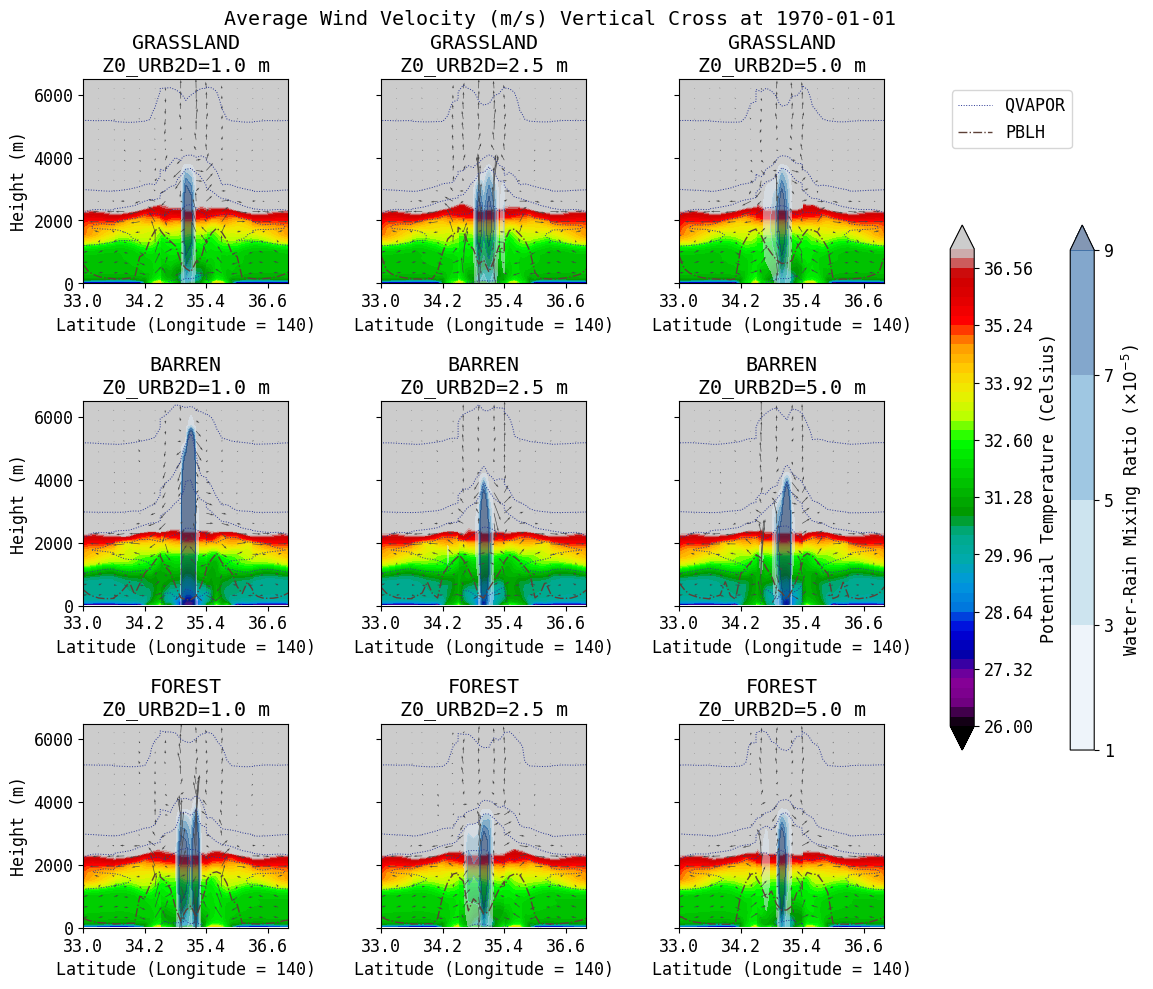

In [26]:
import subprocess

print(f'Starting visualization for vert-wind-contour')

if is_py:
    for image_name in glob(image_dir + '*.png'):
        os.remove(image_name)
    generate_video()
    subprocess.call(['/home/guc/scripts/visualize/tmp-generate-video.sh'])
    subprocess.call(['mv', 'out.mp4', root_dir + f'results/{INDEPENDENT_VAR}-vert-contour-{len(glob(root_dir + f'results/{INDEPENDENT_VAR}-vert-contour-*.mp4')) + 1}.mp4'])
    print('Done!!')
else:
    generate_frame(70)
    # plt.savefig('/home/guc/results/test-fig.png', bbox_inches='tight')